In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import os
import math
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')


/home/guts/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
path = "/home/guts/Documents"
os.chdir(path)
data_dir = "./accel_data"
merged_data = pd.DataFrame()
for filename in os.listdir(data_dir):
    file_path = os.path.join(data_dir, filename)
    if os.path.isfile(file_path) and filename.endswith('.csv'):
        dataset = pd.read_csv(file_path, header=0, index_col=0)
        dataset.reset_index(inplace=True)
        dataset.columns = ['ds','y']
        dataset['ds'] = pd.to_datetime(dataset['ds'], errors='coerce')
        dataset.dropna(subset=['ds'], inplace=True)
        dataset['ds'] = dataset['ds'].dt.strftime('%Y-%m-%d %H:%M:%S')
        merged_data = pd.concat([merged_data, dataset])
merged_data['ds'] = pd.to_datetime(merged_data['ds'])
merged_data = merged_data[18::1]   
print(merged_data.head())
print(merged_data.tail())

                    ds          y
18 2024-08-09 14:24:13   9.111001
19 2024-08-09 14:24:17  10.033545
20 2024-08-09 14:24:18  10.066121
21 2024-08-09 14:24:19   9.555969
22 2024-08-09 14:24:20  10.167968
                       ds          y
18662 2024-08-10 01:05:10   9.490646
18663 2024-08-10 01:05:13  10.447052
18664 2024-08-10 01:05:15   9.073947
18665 2024-08-10 01:05:16  10.054511
18666 2024-08-10 01:06:57   9.576489


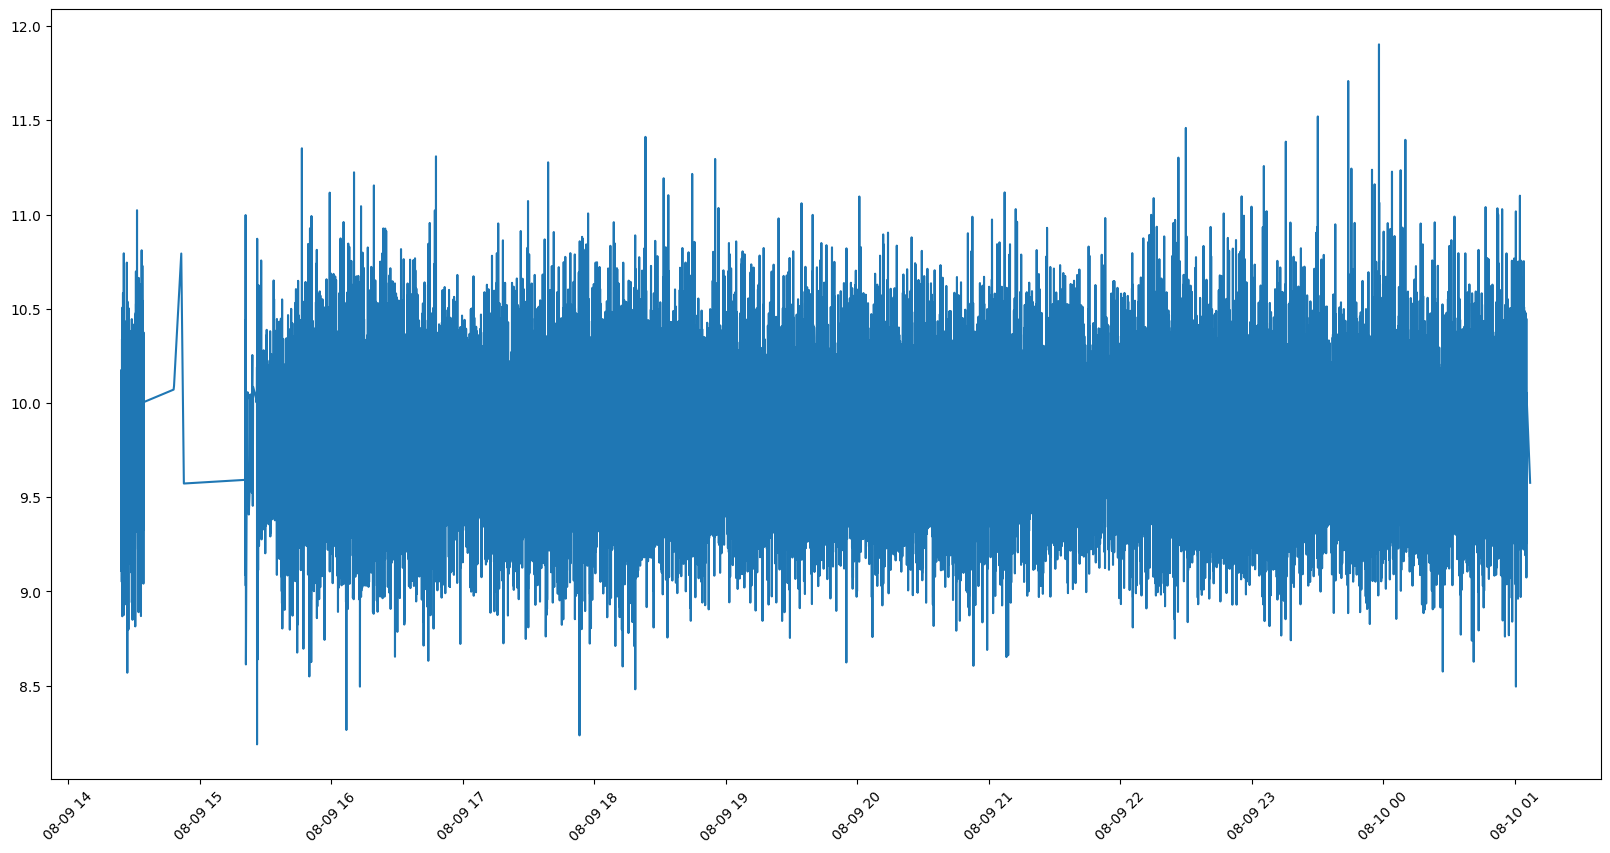

In [3]:
plt.figure(figsize=(20,10))
plt.plot(merged_data['ds'], merged_data['y'])
plt.xticks(rotation=45)
plt.show()

                       ds          y
36    2024-08-09 14:24:57  10.075986
37    2024-08-09 14:24:59  10.439367
38    2024-08-09 14:25:01  10.338649
39    2024-08-09 14:25:02   9.579637
40    2024-08-09 14:25:03   9.471434
...                   ...        ...
11202 2024-08-09 20:58:19  10.043980
11203 2024-08-09 20:58:20   9.381070
11204 2024-08-09 20:58:23  10.321844
11205 2024-08-09 20:58:24   9.466301
11206 2024-08-09 20:58:25  10.186227

[11171 rows x 2 columns]
                       ds          y
11207 2024-08-09 20:58:26  10.092776
11208 2024-08-09 20:58:33   9.487724
11209 2024-08-09 20:58:36   9.324979
11210 2024-08-09 20:58:37   9.566536
11211 2024-08-09 20:58:38   9.579762
...                   ...        ...
18662 2024-08-10 01:05:10   9.490646
18663 2024-08-10 01:05:13  10.447052
18664 2024-08-10 01:05:15   9.073947
18665 2024-08-10 01:05:16  10.054511
18666 2024-08-10 01:06:57   9.576489

[7460 rows x 2 columns]


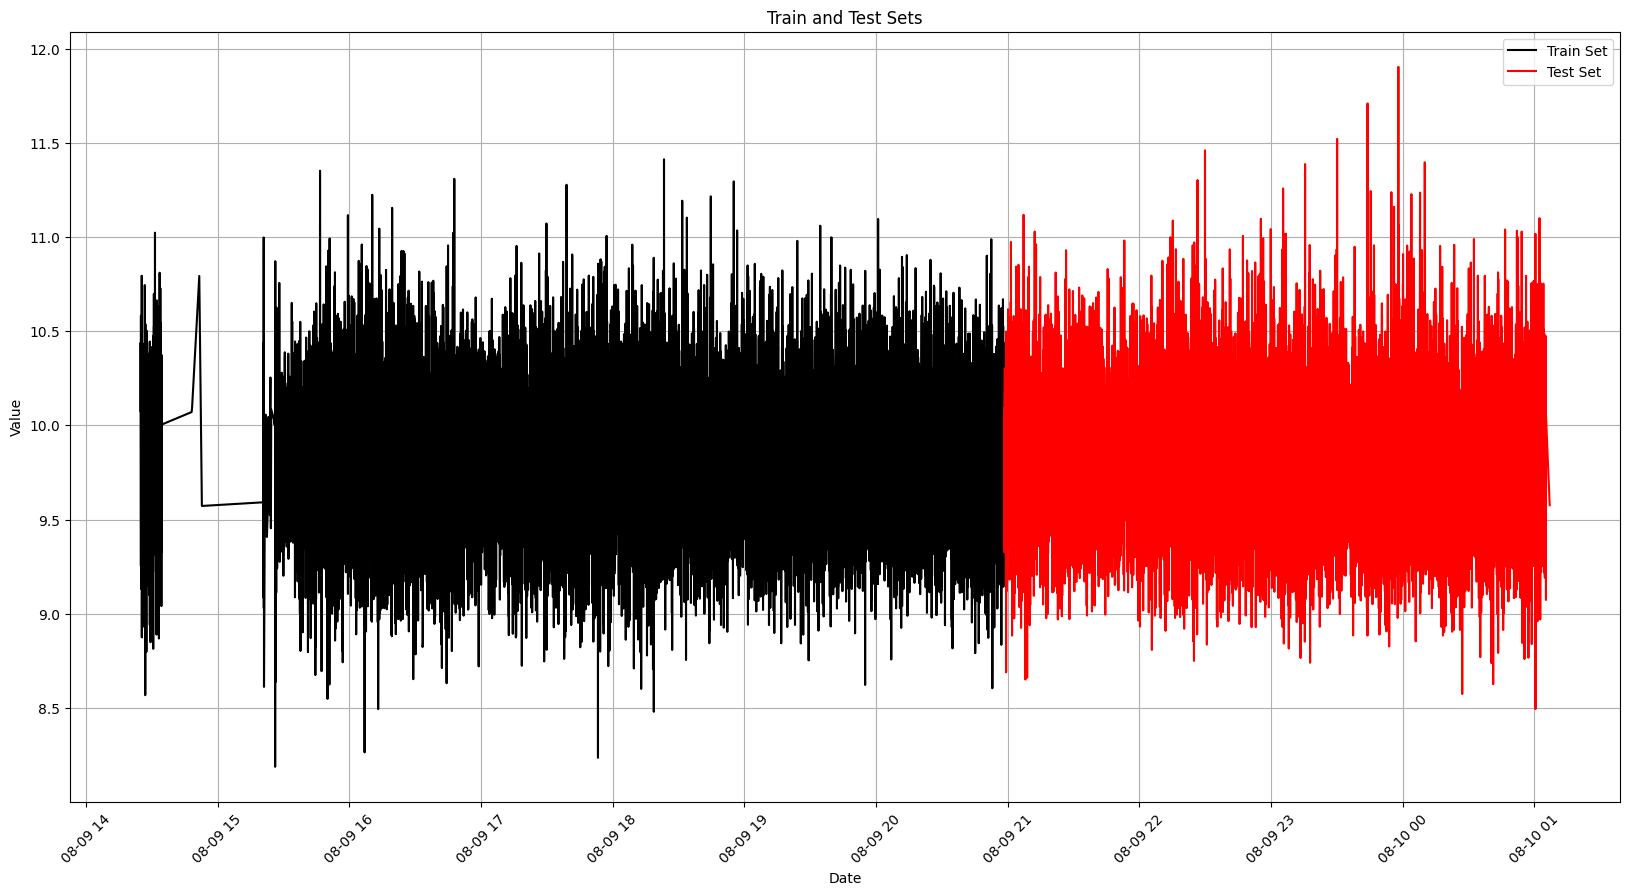

In [4]:
split = int(0.6 * len(merged_data))
# Split the data using the split timestamp
train = merged_data[18:split]
test = merged_data[split:]
print(train)
print(test)
# Plotting
plt.figure(figsize=(20,10))
plt.plot(train['ds'], train['y'], color="black", label="Train Set")
plt.plot(test['ds'], test['y'], color="red", label="Test Set")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Train and Test Sets")
plt.legend()
plt.grid(True)

# Improve date formatting
plt.xticks(rotation=45)

plt.show()
#print("Initial merged_data:")
#print(merged_data.head())
#
#split = int(0.6 * len(merged_data))
#
## Split the data
#train = merged_data[:split]
#test = merged_data[split:]
#
## Debugging step: Print train and test sets before processing
#print("Train set before processing:")
#print(train.head())
#
#print("Test set before processing:")
#print(test.head())
#
## Function to insert NaNs between different hours
#def insert_nans(df):
#    df = df.copy()
#    df['hour'] = df['ds'].dt.hour
#    df['y_with_nans'] = df['y'].where(df['hour'].diff().fillna(0) == 0, np.nan)
#    return df
#
## Apply the function to train and test sets
#train = insert_nans(train)
#test = insert_nans(test)
#
## Debugging step: Print train and test sets after processing
#print("Train set after processing:")
#print(train.head())
#
#print("Test set after processing:")
#print(test.head())
#
## Plotting
#plt.figure(figsize=(20,10))
#plt.plot(train['ds'], train['y_with_nans'], color="black", label="Train Set")
#plt.plot(test['ds'], test['y_with_nans'], color="red", label="Test Set")
#plt.xlabel("Date")
#plt.ylabel("Value")
#plt.title("Train and Test Sets")
#plt.legend()
#plt.grid(True)
#
## Improve date formatting
#plt.xticks(rotation=45)
#
#plt.show()
#

In [5]:
model = pm.auto_arima(train['y'], 
                      start_p=1, start_q=1,
                      test='adf',  # Use ADF test to find optimal 'd'
                      max_p=5, max_q=5,
                      m=10,  # Frequency of series
                      start_P=0, 
                      seasonal=True, 
                      d=1,  # Apply differencing
                      D=1,  # Seasonal differencing
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[10]             : AIC=inf, Time=30.90 sec
 ARIMA(0,1,0)(0,1,0)[10]             : AIC=27369.643, Time=0.45 sec
 ARIMA(1,1,0)(1,1,0)[10]             : AIC=21659.129, Time=3.76 sec
 ARIMA(0,1,1)(0,1,1)[10]             : AIC=inf, Time=15.26 sec
 ARIMA(1,1,0)(0,1,0)[10]             : AIC=25056.106, Time=0.58 sec
 ARIMA(1,1,0)(2,1,0)[10]             : AIC=20435.579, Time=6.88 sec
 ARIMA(1,1,0)(2,1,1)[10]             : AIC=inf, Time=29.14 sec
 ARIMA(1,1,0)(1,1,1)[10]             : AIC=inf, Time=16.86 sec
 ARIMA(0,1,0)(2,1,0)[10]             : AIC=22776.077, Time=4.35 sec
 ARIMA(2,1,0)(2,1,0)[10]             : AIC=19495.844, Time=7.93 sec
 ARIMA(2,1,0)(1,1,0)[10]             : AIC=20713.587, Time=5.86 sec
 ARIMA(2,1,0)(2,1,1)[10]             : AIC=inf, Time=47.59 sec
 ARIMA(2,1,0)(1,1,1)[10]             : AIC=inf, Time=25.25 sec
 ARIMA(3,1,0)(2,1,0)[10]             : AIC=18851.913, Time=12.14 sec
 ARIMA(3,1,0)(1,1,0)[10]          

In [27]:
print(model.summary())
forecasts = model.predict(n_periods=len(test))
forecasts

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 1570
Model:             SARIMAX(5, 1, 0)x(2, 1, 0, 10)   Log Likelihood               -2854.494
Date:                            Mon, 05 Aug 2024   AIC                           5724.988
Time:                                    16:21:01   BIC                           5767.802
Sample:                                         0   HQIC                          5740.907
                                           - 1570                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0970      0.023    -48.670      0.000      -1.141      -1.053
ar.L2         -1.0861      0.033   

1606     8.395530
1607    10.523533
1608     9.732138
1609     9.705467
1610    10.503405
          ...    
2661     7.672375
2662     8.187397
2663     8.167177
2664     7.642842
2665     9.438717
Length: 1060, dtype: float64

                      ds          y
1606 2024-08-05 15:21:35   8.395530
1607 2024-08-05 15:21:36  10.523533
1608 2024-08-05 15:21:37   9.732138
1609 2024-08-05 15:21:38   9.705467
1610 2024-08-05 15:21:39  10.503405
...                  ...        ...
2661 2024-08-05 15:41:56   7.672375
2662 2024-08-05 15:41:57   8.187397
2663 2024-08-05 15:41:58   8.167177
2664 2024-08-05 15:41:59   7.642842
2665 2024-08-05 15:42:00   9.438717

[1060 rows x 2 columns]


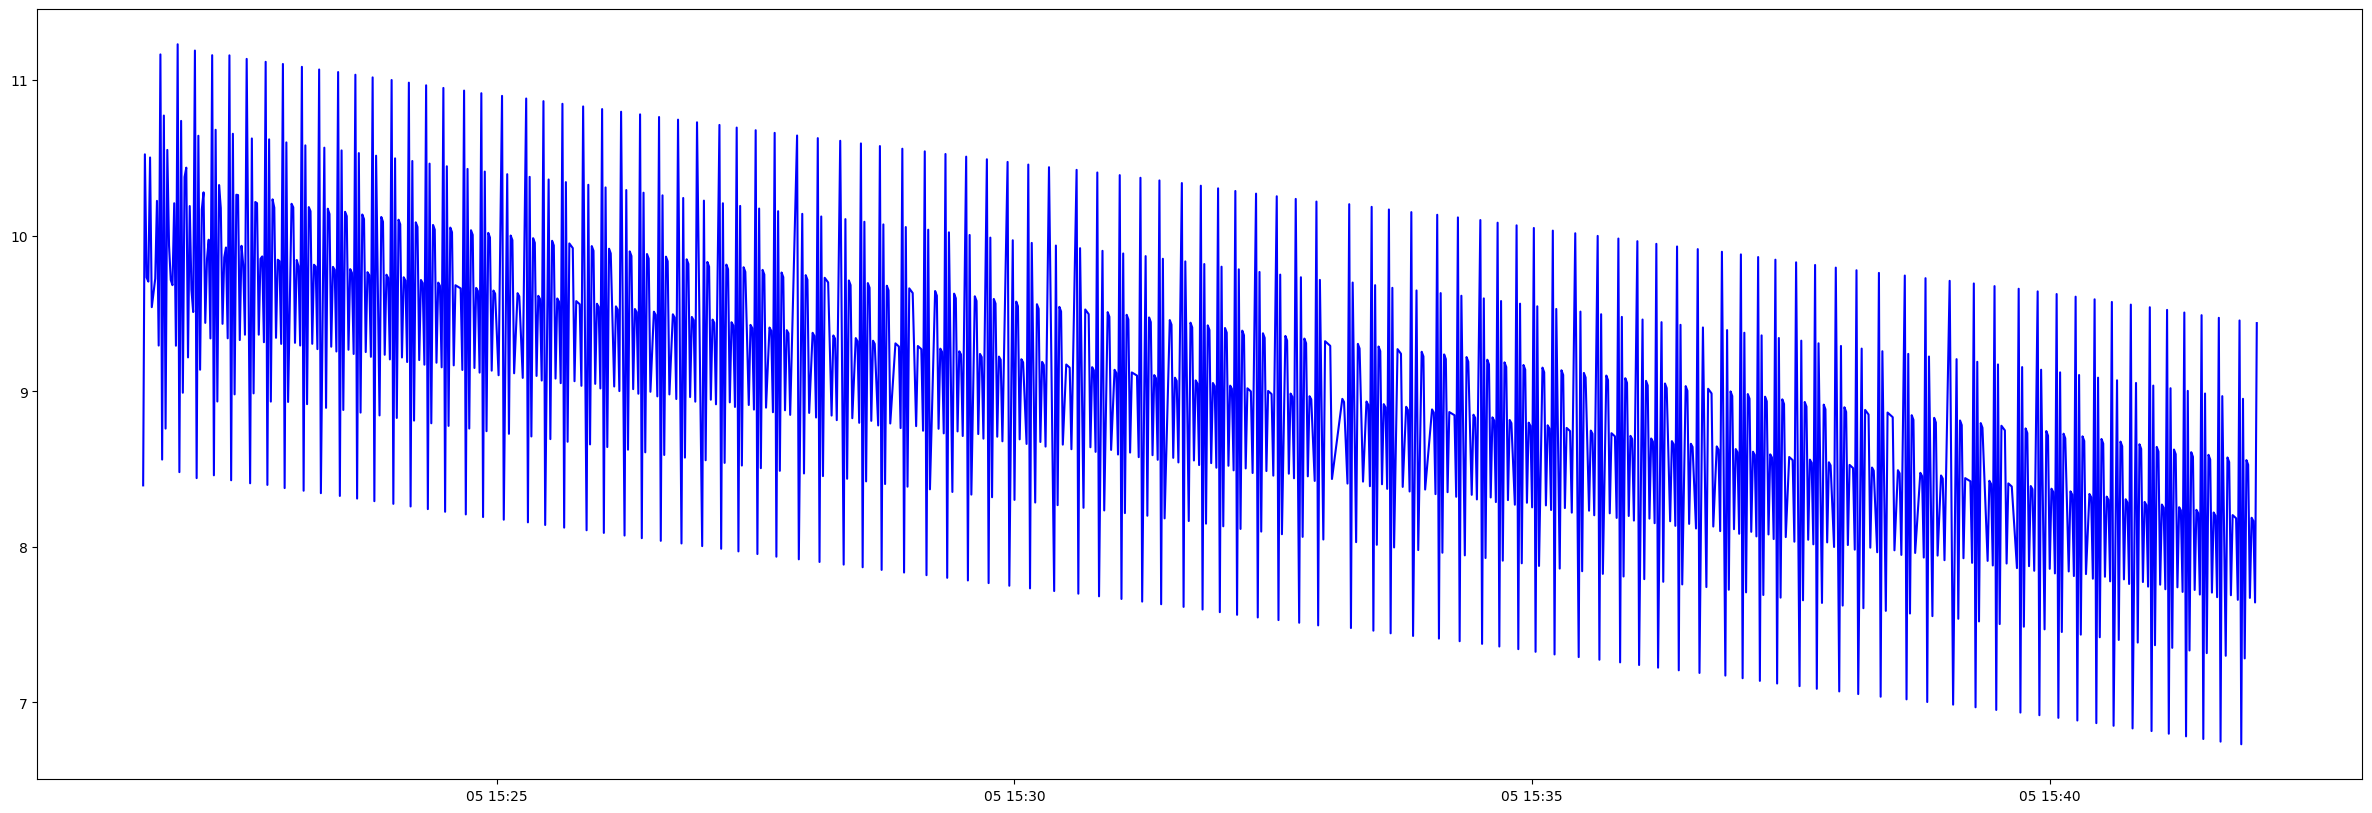

In [28]:
forecasts_df = pd.DataFrame()
forecasts_df['ds'] = test['ds']
forecasts_df['y'] = forecasts.values
forecasts_df['ds'] = pd.to_datetime(forecasts_df['ds'])
#forecasts_with_nans = insert_nans(forecasts_df)
print((forecasts_df))
plt.figure(figsize=(30, 10))
plt.plot(forecasts_df['ds'], forecasts_df['y'], color="blue", label="Predictions")

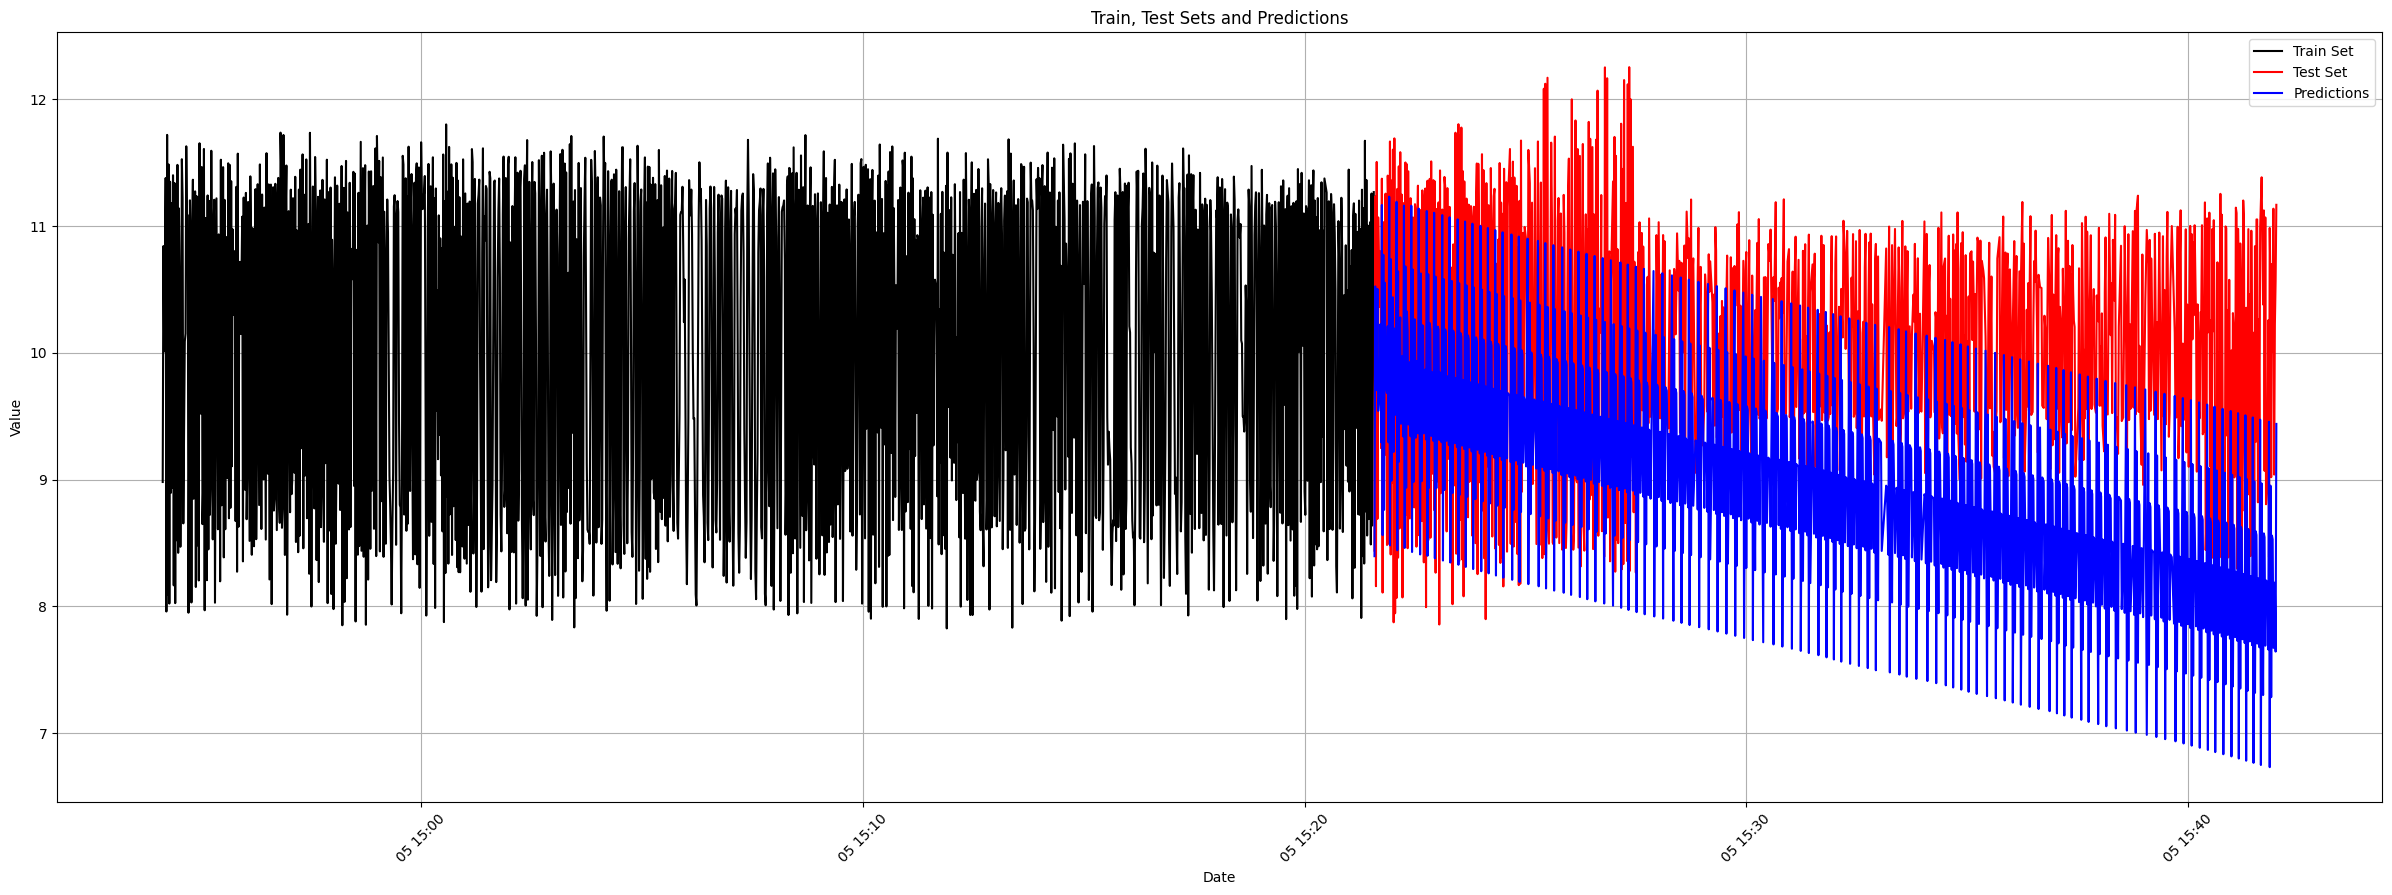

In [30]:
plt.figure(figsize=(30,10))
plt.plot(train['ds'], train['y'], color="black", label="Train Set")
plt.plot(test['ds'], test['y'], color="red", label="Test Set")
plt.plot(forecasts_df['ds'], forecasts_df['y'], color="blue", label="Predictions")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Train, Test Sets and Predictions")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

